Датасет **tmdb_data** содержит информацию о фильмах, собранную с платформы TMDB

- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `production_countries` - список стран, учавствовавших в производстве фильма

Датасет **cpi_data** содержит информацию о значении cpi на каждый месяц с 1913 года

- `cpi_date` - дата (ГГГГ-ММ-01)
- `cpi` - значение cpi

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [76]:
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns', None)

- Загружаем датасеты, оставляя необходимые столбцы 
- Преобразовываем типы данных (`year` в датасете cpi_data и `release_date` в tmdb_data)
- Переименовываем столбец `year` в датасете cpi_data на `cpi_date`

In [77]:
columns_tmdb = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries"   
]

In [78]:
df_tmdb = pd.read_csv(
    '../data/raw/tmdb_data.csv',
    usecols=columns_tmdb,
    parse_dates=['release_date']
    )
df_cpi = pd.read_csv(
    '../data/raw/cpi_data.csv',
    parse_dates=['year']
    ).rename(columns={'year': 'cpi_date'})

In [79]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cpi_date  1348 non-null   datetime64[ns]
 1   cpi       1348 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.2 KB


In [80]:
print(f'''Датасет df_cpi состоит из:
- {df_cpi.shape[0]} строк
- {df_cpi.shape[1]} столбцов''')

Датасет df_cpi состоит из:
- 1348 строк
- 2 столбцов


In [81]:
df_cpi.head(3)

,cpi_date,cpi
0,1913-01-01,9.80
1,1913-02-01,9.80
2,1913-03-01,9.80


- Объявляем переменную **latest_cpi**, которая будет хранить информацию о последнем зафиксированном значении cpi

In [82]:
latest_cpi = df_cpi.loc[df_cpi['cpi_date'].idxmax(), 'cpi']
print(f'Значение актуального CPI = {latest_cpi}')

Значение актуального CPI = 320.795


In [83]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238452 entries, 0 to 1238451
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1238452 non-null  int64         
 1   title                 1238439 non-null  object        
 2   vote_average          1238452 non-null  float64       
 3   release_date          1006342 non-null  datetime64[ns]
 4   revenue               1238452 non-null  int64         
 5   budget                1238452 non-null  int64         
 6   original_language     1238452 non-null  object        
 7   original_title        1238439 non-null  object        
 8   genres                721907 non-null   object        
 9   production_countries  667901 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 94.5+ MB


In [84]:
print(f'''Датасет df_tmdb состоит из:
- {df_tmdb.shape[0]} строк
- {df_tmdb.shape[1]} столбцов''')

Датасет df_tmdb состоит из:
- 1238452 строк
- 10 столбцов


- Сохраняем в переменную **old_rows** данные о количестве строк в датасете с фильмами до предобработки, чтобы позже оценить количество удаленной информации

In [85]:
old_rows = df_tmdb.shape[0]
old_rows

1238452

### Смена типов данных

In [86]:
df_tmdb.dtypes

id                               int64
title                           object
vote_average                   float64
release_date            datetime64[ns]
revenue                          int64
budget                           int64
original_language               object
original_title                  object
genres                          object
production_countries            object
dtype: object

Типы данных корректны

- Преобразуем содержимое строковых данных к нижнему регистру, чтобы избежать возможных дубликатов

In [87]:
str_column = df_tmdb.select_dtypes(include='object').columns
for col in str_column:
    df_tmdb[col] = df_tmdb[col].str.lower().str.strip()
df_tmdb[str_column].head(3)

,title,original_language,original_title,genres,production_countries
0,inception,en,inception,"action, science fiction, adventure","united kingdom, united states of america"
1,interstellar,en,interstellar,"adventure, drama, science fiction","united kingdom, united states of america"
2,the dark knight,en,the dark knight,"drama, action, crime, thriller","united kingdom, united states of america"


### Объединяем датафреймы

- Объединяем df_tmdb и df_cpi по дате начала месяца. Для этого добавим новый столбец в df_tmdb, который приведет release_date к началу месяца

In [88]:
df_tmdb['release_month'] = (df_tmdb['release_date']
                            .dt.to_period('M')
                            .dt.to_timestamp()
                            )
df_tmdb['release_month'].head(2)

0   2010-07-01
1   2014-11-01
Name: release_month, dtype: datetime64[ns]

In [89]:
df_merged = df_tmdb.merge(df_cpi,
                          left_on='release_month',
                          right_on='cpi_date',
                          how='inner')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992822 entries, 0 to 992821
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    992822 non-null  int64         
 1   title                 992818 non-null  object        
 2   vote_average          992822 non-null  float64       
 3   release_date          992822 non-null  datetime64[ns]
 4   revenue               992822 non-null  int64         
 5   budget                992822 non-null  int64         
 6   original_language     992822 non-null  object        
 7   original_title        992818 non-null  object        
 8   genres                664743 non-null  object        
 9   production_countries  629555 non-null  object        
 10  release_month         992822 non-null  datetime64[ns]
 11  cpi_date              992822 non-null  datetime64[ns]
 12  cpi                   992822 non-null  float64       
dtyp

### Проверка на дубликаты

In [90]:
print(f'Найдено {df_merged.duplicated().sum()} полных дубликатов строк')

Найдено 169 полных дубликатов строк


- удаляем их

In [91]:
df_merged = df_merged.drop_duplicates().reset_index(drop=True)
df_merged.duplicated().sum()

np.int64(0)

- Проверим, есть ли дубликаты по столбцам с информацией об оригинальном названии фильма и датой релиза

In [92]:
print(f'''Найдено {df_merged[['original_title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 1928 дубликатов


- Фильмы с одинаковым оригинальным названием и одинаковой датой релиза могут указывать на дубликаты - удаляем их

In [93]:
df_merged = df_merged.drop_duplicates(subset=['original_title', 'release_date'])
df_merged = df_merged.reset_index(drop=True)

Одинаковые названия фильмов действительно могут встречаться - главное, чтобы даты релизов не совпадали

- Теперь проверим дубликаты, связанные с англоязычным названием и датой релиза

In [94]:
print(f'''Найдено {df_merged[['title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 343 дубликатов


In [95]:
df_merged[df_merged.duplicated(subset=['title', 'release_date'], keep=False)][['title', 'release_date']].value_counts()

title                       release_date
fatal love                  1993-01-01      3
chosen 2                    2020-01-13      3
resurrection of love        1973-01-01      2
run!                        2013-10-23      2
rolling                     2016-09-16      2
                                           ..
god's gift                  1998-01-01      2
girls                       2014-07-30      2
ghost story of kam pin mui  1991-06-22      2
ghost                       2023-10-19      2
zhanxiou village            2007-05-20      2
Name: count, Length: 341, dtype: int64

Проверим фильм  `chosen 2`, чтобы понять, стоит ли нам считать совпадение по дате релиза и англоязычному названию - дубликатами

In [96]:
df_merged[df_merged['title'] == 'chosen 2']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
449190,1160180,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅰ救赎,NaN,NaN,2020-01-01,2020-01-01,257.97
449193,1160183,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅱ同盟,NaN,NaN,2020-01-01,2020-01-01,257.97
449194,1160184,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅲ重生,NaN,NaN,2020-01-01,2020-01-01,257.97


In [97]:
df_merged[df_merged['title'] == 'zhanxiou village']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
481131,1405386,zhanxiou village,0.00,2007-05-20,0,0,zh,朱辛庄,NaN,china,2007-05-01,2007-05-01,207.95
514756,1469333,zhanxiou village,0.00,2007-05-20,0,0,en,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95
563002,1264836,zhanxiou village,0.00,2007-05-15,0,0,fr,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95


- Оригинальные названия разные, судя по всему, это могут быть разные части одного проекта, релизнутые в один день. 

Совпадения по дате релиза и англоязычному названию НЕ указывают на дубликаты

In [98]:
new_rows = df_merged.shape[0]
print(f'''Было удалено {old_rows - new_rows} строк.
Мы лишились {round((old_rows - new_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 247727 строк.
Мы лишились 20.0% данных


### Анализ пропусков

In [99]:
df_merged.isnull().sum().sort_values(ascending=False)

production_countries    362016
genres                  327262
title                        4
original_title               4
id                           0
vote_average                 0
release_date                 0
revenue                      0
budget                       0
original_language            0
release_month                0
cpi_date                     0
cpi                          0
dtype: int64

In [100]:
(df_merged.isnull().mean() * 100).sort_values(ascending=False).round(2)

production_countries   36.54
genres                 33.03
title                   0.00
original_title          0.00
id                      0.00
vote_average            0.00
release_date            0.00
revenue                 0.00
budget                  0.00
original_language       0.00
release_month           0.00
cpi_date                0.00
cpi                     0.00
dtype: float64

У нас отсутствует свыше 40% информации по странам производства и жанрам. Также есть пропуски в 17% информации о дате релиза, 18% пропусков по информации о cpi.


- Данные CPI у нас есть с 1913 года, поэтому исключим фильмы, для которых не определено CPI

In [101]:
df_merged = df_merged[df_merged['cpi'].notna()].reset_index(drop=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990725 entries, 0 to 990724
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    990725 non-null  int64         
 1   title                 990721 non-null  object        
 2   vote_average          990725 non-null  float64       
 3   release_date          990725 non-null  datetime64[ns]
 4   revenue               990725 non-null  int64         
 5   budget                990725 non-null  int64         
 6   original_language     990725 non-null  object        
 7   original_title        990721 non-null  object        
 8   genres                663463 non-null  object        
 9   production_countries  628709 non-null  object        
 10  release_month         990725 non-null  datetime64[ns]
 11  cpi_date              990725 non-null  datetime64[ns]
 12  cpi                   990725 non-null  float64       
dtyp

Кажется, что в столбце бюджета и дохода пропусков нет, однако там пропущенные значения могут обозначаться как 0

In [102]:
df_merged['budget'].value_counts()

budget
0           941173
100           1556
1000          1383
10000         1296
500           1199
             ...  
1465000          1
401000           1
777900           1
13339000         1
78615            1
Name: count, Length: 5305, dtype: int64

### Анализ REVENUE

In [103]:
def millions(x, pos):
    '''Функция используется с FuncFormat 
    для форматирования значения x в миллионах 
    с округлением до одного знака после запятой'''
    return f'{x * 1e-6:.1f}'

In [104]:
df_merged['revenue'].value_counts()

revenue
0           971352
100            349
1              314
10             164
1000           161
             ...  
1749201          1
26527510         1
74918            1
53672080         1
66436            1
Name: count, Length: 14112, dtype: int64

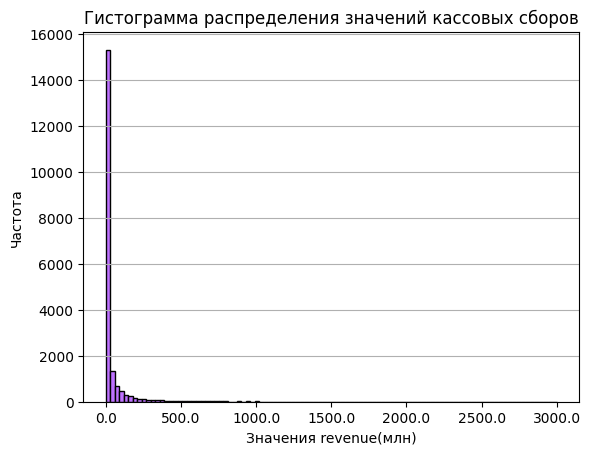

In [105]:
plt.hist(df_merged[df_merged['revenue'] > 0]['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Значения revenue(млн)')
plt.ylabel('Частота')

plt.show()

Большая часть данных хранит в себе значение "0" в столбце кассовых сборов (доходов). 

In [106]:
df_merged['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,990725.00,767777.37,18647121.43,-12.00,0.00,0.00,0.00,3000000000.00


Высокое значение стандартного отклонения указывает на большой разброс данных - есть выбросы. Учитывая, что 75-й квантиль равен 0, можно сделать вывод - большинство данных не имеют информации о кассовых сборах  

In [107]:
print(f'''Ненулевых значений обнаружено - {df_merged[df_merged['revenue'] > 0]['revenue'].count()}''')

Ненулевых значений обнаружено - 19372


- Объявим переменную, которая будет хранить булевую маску со значениями, где кассовые сборы были больше 0

In [108]:
filter_not_zero = df_merged['revenue'] > 0
filter_not_zero.head(3)

0    True
1    True
2    True
Name: revenue, dtype: bool

- Объявим переменные, которые будут хранить значения 30-го и 99-го квантиля

In [109]:
quantile_min = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.3)
print(f'''Значение 30-го процентиля = {quantile_min.round(2)}''')

Значение 30-го процентиля = 171858.6


In [110]:
quantile_max = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.99)
print(f'''Значение 99-го процентиля = {quantile_max.round(2)}''')

Значение 99-го процентиля = 627142916.53


Отфильтруем наш датасет по значениям от 30-го квантиля до 99-го, чтобы избавиться от аномальных значений 

In [111]:
df_filtered = df_merged[(df_merged['revenue'] > quantile_min) & (df_merged['revenue'] < quantile_max)]
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82


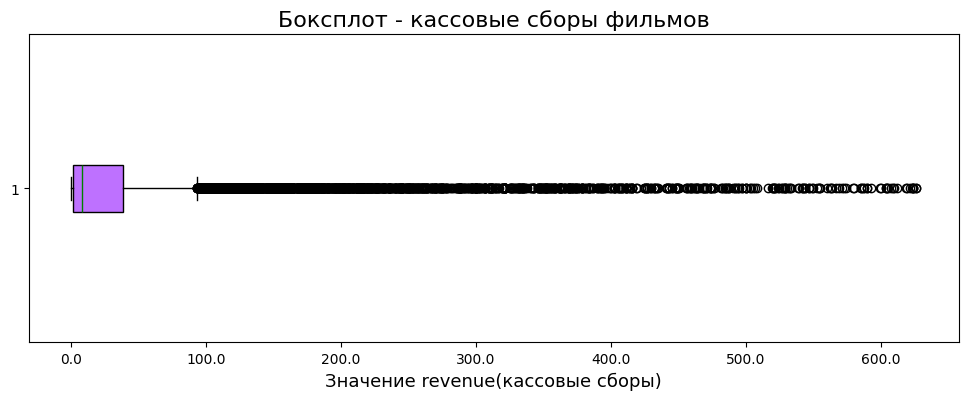

In [112]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['revenue'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.title('Боксплот - кассовые сборы фильмов', fontsize=16)
plt.xlabel('Значение revenue(кассовые сборы)', fontsize=13)

plt.show()

На боксплоте видно, что все аномальные значения находятся справа - их довольно много. 
Это бестселлеры, которые действительно получили огромные кассовые сборы

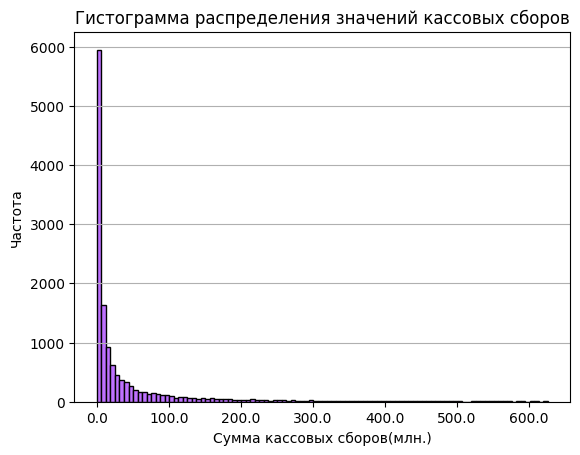

In [113]:
plt.hist(df_filtered['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Сумма кассовых сборов(млн.)')
plt.ylabel('Частота')

plt.show()

In [114]:
df_filtered['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,13366.00,42487556.46,84868202.72,171958.00,1800000.00,8746005.50,38504341.75,626203271.00


In [115]:
filtered_rows = df_filtered.shape[0]
print(f'''Было удалено {old_rows - filtered_rows} строк.
Мы лишились {round((old_rows - filtered_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 1225086 строк.
Мы лишились 98.92% данных


### Анализ BUDGET

In [116]:
print(f'''{df_filtered[df_filtered['budget'] == 0].shape[0]} количество фильмов не содержат информации о бюджете ''')

4358 количество фильмов не содержат информации о бюджете 


In [117]:
print(f'''{df_filtered[df_filtered['budget'] > 0].shape[0]} количество фильмов содержат информацию о бюджете''')

9008 количество фильмов содержат информацию о бюджете


In [118]:
df_filtered['budget'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
budget,13366.00,15803891.14,30140642.57,0.00,0.00,3000000.00,19000000.00,645654654.00


Мы видим большое стандратное отклонение, которое указывает на выбросы. У 25% фильмов отсутсвует информация о бюджете

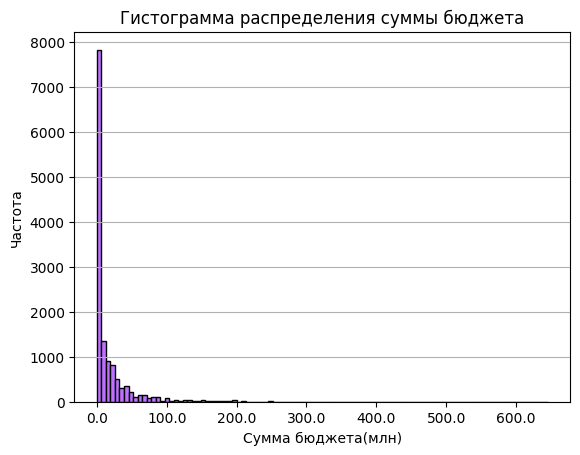

In [119]:
plt.hist(df_filtered['budget'],
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения суммы бюджета')
plt.xlabel('Сумма бюджета(млн)')
plt.ylabel('Частота')


plt.show()

- Распределение сильно смещено вправо: встречаются редкие, но очень крупные бюджеты
- Около 25% фильмов имеют нулевой бюджет, это значит, что данные либо отсутствуют - это типичная ситуация для фильмов, финансируемых: государственными субсидиями, международными фондами, кинокомиссиями.

По этой причине нулевые значения мы оставляем 

### Анализ PRODUCTION_COUNTRIES

In [120]:
df_filtered['production_countries'].value_counts()

production_countries
united states of america                                           5848
india                                                               700
united kingdom, united states of america                            418
japan                                                               412
united kingdom                                                      328
                                                                   ... 
united states of america, belgium, netherlands, united kingdom        1
netherlands, germany, united states of america                        1
spain, france, united states of america                               1
canada, france, spain, united kingdom, united states of america       1
kazakhstan                                                            1
Name: count, Length: 1131, dtype: int64

В данных по странам производства присутствуют строки с несколькими странами. Будем брать первую страну из списка, так как чаще всего именно она отражает основную страну производства. Такой подход соответствует распространённой практике в исследовательских работах и научных публикациях, где при множественном указании стран приоритет отдаётся первой по порядку как представителю основного продюсера проекта.

In [121]:
df_filtered['main_country'] = (
                                df_filtered['production_countries']
                               .str.split(',', expand=True)[0]
                               )

/tmp/ipykernel_4459/1004472657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['main_country'] = (


In [122]:
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi,main_country
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20,united states of america
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40,united states of america
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82,united states of america


In [123]:
df_filtered['main_country'].value_counts()

main_country
united states of america    6040
united kingdom               810
india                        742
france                       706
canada                       496
                            ... 
senegal                        1
namibia                        1
macedonia                      1
bosnia and herzegovina         1
kazakhstan                     1
Name: count, Length: 109, dtype: int64

In [124]:
df_country = df_filtered['main_country'].value_counts(ascending=True).reset_index()
df_country.head(2)

,main_country,count
0,kazakhstan,1
1,lebanon,1


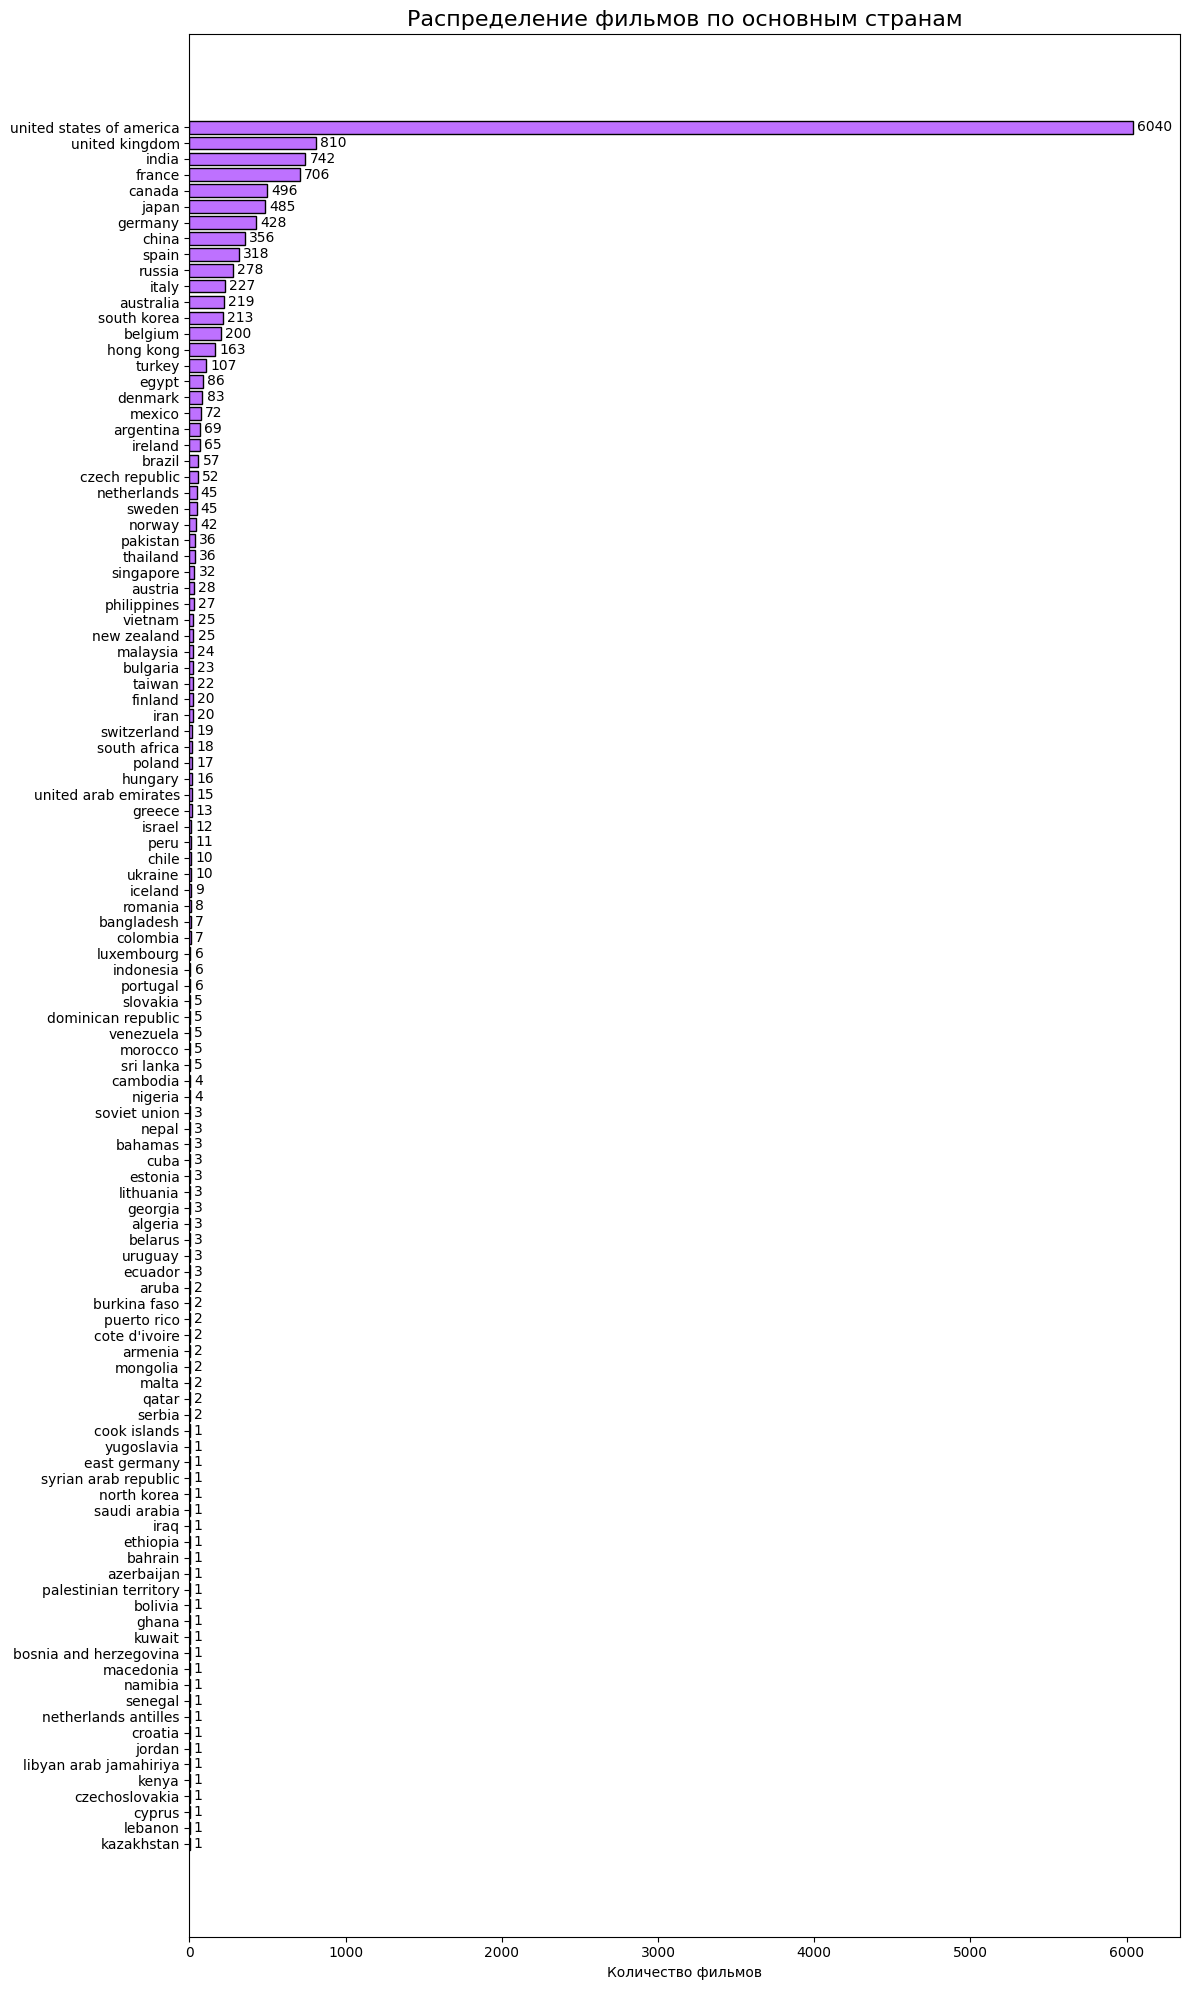

In [125]:
plt.figure(figsize=(12, 20))

bars = plt.barh(
    y=df_country['main_country'],
    width=df_country['count'],
    color='#be71ff',
    edgecolor='black'
)

plt.gca().bar_label(bars, fmt='%.0f', padding=3)

plt.xlabel('Количество фильмов')
plt.title('Распределение фильмов по основным странам', fontsize=16)
plt.tight_layout()
plt.show()

### Анализ VOTE_AVERTAGE

In [126]:
df_filtered['vote_average'].value_counts()

vote_average
0.00    378
6.00    223
7.00    150
6.50    140
6.20    129
       ... 
5.21      1
4.95      1
5.17      1
6.02      1
8.44      1
Name: count, Length: 3262, dtype: int64

У нас действительно могут встречаться фильмы без оценок пользователей, так что тут значение 0 не критично

In [127]:
df_filtered['vote_average'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
vote_average,13366.00,6.18,1.47,0.00,5.75,6.39,7.00,10.00


Стандартное отклонение не критичное, а значит вариативность умеренная

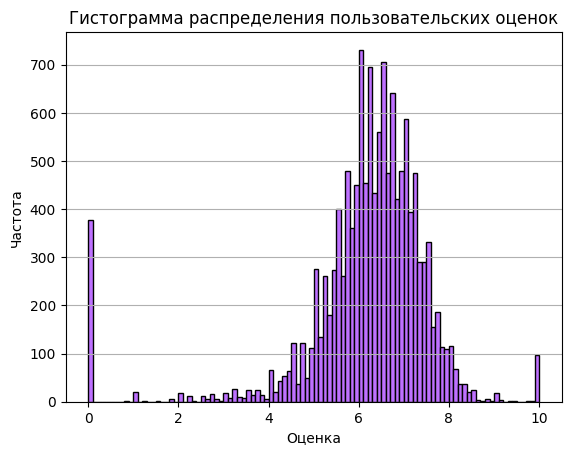

In [128]:
plt.hist(df_filtered['vote_average'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.grid(axis='y')

plt.title('Гистограмма распределения пользовательских оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.show()

- Распределение с левосторонней ассиметрией
- Вытянутый левый хвост обусловлен наличием свыше 900 нулевых оценок

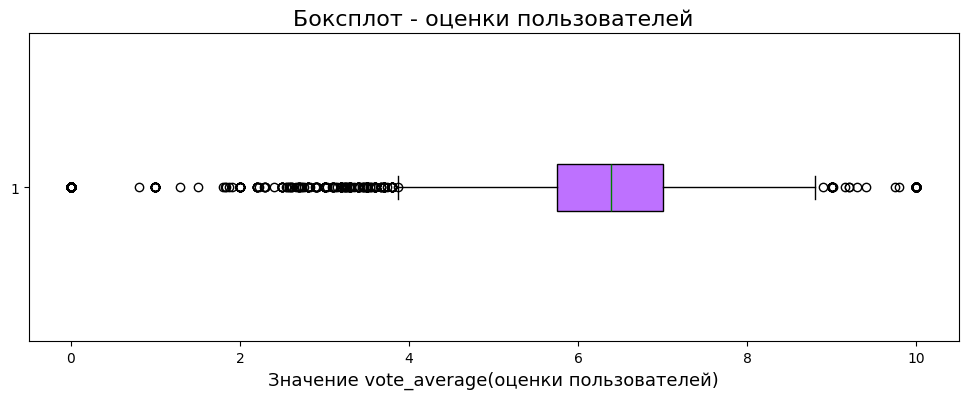

In [129]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['vote_average'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.title('Боксплот - оценки пользователей', fontsize=16)
plt.xlabel('Значение vote_average(оценки пользователей)', fontsize=13)

plt.show()

- Основная часть оценок приходится на значения ~5.6-6.97. Слева у нас наблюдается много выбросов, справа выбросы тоже есть, но их меньше. 
- Низкая оценка, как и ее отсутствие, может быть связана с малой популярностью фильма, возможно даже полным отсутствием популярности. 
- Высокая оценка может быть связана с большой положительной популярностью фильма, а также присутствует и такой вариант, что фильм не особо известен, у него не так много оценок - но все высокие. Тогда наша средняя оценка сильно завышается

### Уникальные значения

- Уникальные значения в жанрах

In [130]:
df_filtered['genres'].value_counts()

genres
drama                                                            984
comedy                                                           914
drama, romance                                                   485
comedy, drama                                                    425
comedy, romance                                                  409
                                                                ... 
mystery, drama, thriller, comedy                                   1
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
drama, family, documentary                                         1
Name: count, Length: 2326, dtype: int64

- У нас встречаются строки с перечислением нескольких жанров. Для нашего исследования мы оставляем их в исходном виде. При построении дашборда предполагается использовать проверку по жанрам через оператор LIKE (SQL)

In [131]:
print(f'''У {df_filtered['genres'].isnull().sum()} фильмов отсутствует информация о жанрах''')

У 90 фильмов отсутствует информация о жанрах


- Нулевые значения можно заменить на "undefined"

In [132]:
df_filtered['genres'] = df_filtered['genres'].fillna('undefined')

/tmp/ipykernel_4459/3432640581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['genres'] = df_filtered['genres'].fillna('undefined')


In [133]:
df_filtered['genres'].value_counts()

genres
drama                                                            984
comedy                                                           914
drama, romance                                                   485
comedy, drama                                                    425
comedy, romance                                                  409
                                                                ... 
mystery, drama, thriller, comedy                                   1
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
drama, family, documentary                                         1
Name: count, Length: 2327, dtype: int64

Изучим уникальные данные по столбцу с original_language

In [134]:
df_tmdb['original_language'].value_counts()

original_language
en    672927
fr     72271
es     63456
de     57695
ja     54228
       ...  
kj         1
kv         1
ik         1
hz         1
ii         1
Name: count, Length: 176, dtype: int64

- Пропуски отсутствуют - данные выглядят полными

### Учет инфляции 

Добавим два столбца:
- `current_budget` - бюджет с учетом инфляции
- `current_revenue` - кассовые сборы с учетом инфляции

In [135]:
df_filtered['current_budget'] = (
    df_filtered['budget'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['budget', 'current_budget']].head(3)

/tmp/ipykernel_4459/4200148618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_budget'] = (


,budget,current_budget
7,63000000,120155083.23
9,8500000,18251388.89
12,140000000,209061878.85


In [136]:
df_filtered['current_revenue'] = (
    df_filtered['revenue'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['revenue', 'current_revenue']].head(3)

/tmp/ipykernel_4459/3040352102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_revenue'] = (


,revenue,current_revenue
7,100853753,192350652.16
9,213900000,459290833.33
12,585174222,873840159.32


### Итог 

In [137]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13366 entries, 7 to 989290
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13366 non-null  int64         
 1   title                 13366 non-null  object        
 2   vote_average          13366 non-null  float64       
 3   release_date          13366 non-null  datetime64[ns]
 4   revenue               13366 non-null  int64         
 5   budget                13366 non-null  int64         
 6   original_language     13366 non-null  object        
 7   original_title        13366 non-null  object        
 8   genres                13366 non-null  object        
 9   production_countries  13023 non-null  object        
 10  release_month         13366 non-null  datetime64[ns]
 11  cpi_date              13366 non-null  datetime64[ns]
 12  cpi                   13366 non-null  float64       
 13  main_country        

In [138]:
columns_to_keep = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "main_country",
    "cpi", 
    "current_budget",
    "current_revenue"  
]

In [139]:
df_filtered = df_filtered[columns_to_keep].copy()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13366 entries, 0 to 13365
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 13366 non-null  int64         
 1   title              13366 non-null  object        
 2   original_title     13366 non-null  object        
 3   original_language  13366 non-null  object        
 4   release_date       13366 non-null  datetime64[ns]
 5   genres             13366 non-null  object        
 6   budget             13366 non-null  int64         
 7   revenue            13366 non-null  int64         
 8   vote_average       13366 non-null  float64       
 9   main_country       13023 non-null  object        
 10  cpi                13366 non-null  float64       
 11  current_budget     13366 non-null  float64       
 12  current_revenue    13366 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory 

In [140]:
df_filtered['release_date'].min()


Timestamp('1913-11-24 00:00:00')

In [141]:
print(f'''Наш отфильтрованный и предобработанный датасет состоит из:
- {df_filtered.shape[0]} строк
- {df_filtered.shape[1]} столбцов''')

Наш отфильтрованный и предобработанный датасет состоит из:
- 13366 строк
- 13 столбцов




- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `main_country` - главная страна, учавствовавшая в производстве фильма
- `cpi` - cpi на дату выхода фильма
- `latest_cpi` - актуальный cpi
- `current_budget` - сумма бюджета с учетом инфляции
- `current_revenue` - сумма кассовых сборов с учетом инфляции

 ## Графики (примеры + могут дополняться)

**scatter plot - corrent_revenue vs vote_average**


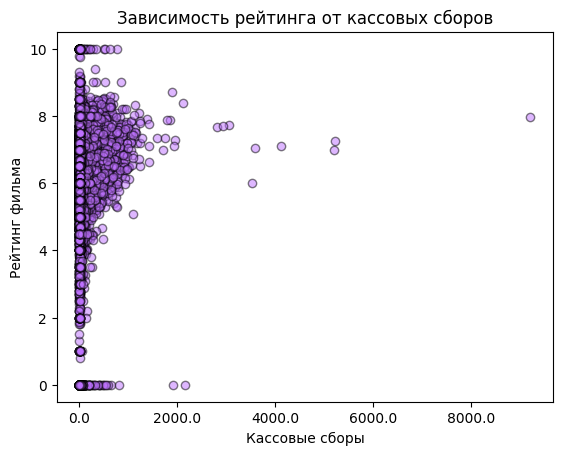

In [142]:
plt.scatter(
    df_filtered['current_revenue'],
    df_filtered['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Уберем выбросы

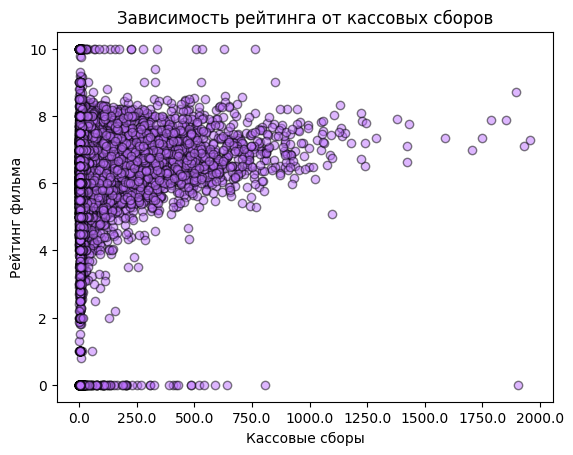

In [143]:
plt.scatter(
    df_filtered[df_filtered['current_revenue'] < 2000000000]['current_revenue'],
    df_filtered[df_filtered['current_revenue'] < 2000000000]['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Большинство фильмов имеют относительно низкие сборы, вне зависимости от рейтинга.
- Высокие сборы - чаще высокие рейтинги. На графике видно, что с увеличением значения кассовых сборов, фильмов становится меньше, однако рейтинг у них держится в районе 6-9.

**Линейный график - кол-во фильмов**

In [144]:
df_filtered['year'] = pd.to_datetime(df_filtered['release_date']).dt.year

In [145]:
films_year = df_filtered['year'].value_counts()
films_year = films_year.reset_index(drop=False)
films_year = films_year.sort_values(by='year')
films_year.head()

,year,count
108,1913,1
106,1914,2
111,1915,1
102,1916,3
105,1918,2


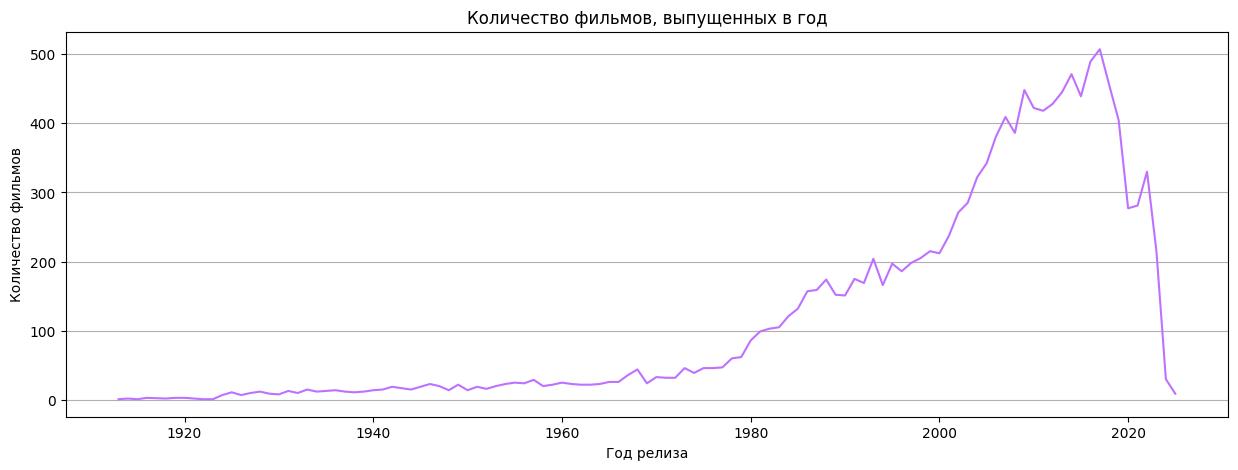

In [146]:
plt.figure(figsize=(15, 5))

plt.plot(films_year['year'],
         films_year['count'],
          color='#be71ff')

plt.title('Количество фильмов, выпущенных в год')
plt.xlabel('Год релиза')
plt.ylabel('Количество фильмов')
plt.grid(axis='y')
plt.show()

продолжение следует...